# Definition

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. Know more about parameters of ARIMA and its limitations, in this free video tutorial

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: $p, d, q$

where,

- $p$ is the order of the AR term, it refers to the number of lags of Y to be used as predictors.
- $q$ is the order of the MA term, it refers to the number of lagged forecast errors that should go into the ARIMA Model.
- $d$ is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for Seasonal ARIMA. More on that once we finish ARIMA.

## AR

$$Y_t=\sum_{i=1}^{p}\phi_i Y_{t-i}+\epsilon_t$$

## MA

$$Y_t=\epsilon_t+\sum_{i=1}^{q}\theta_i \epsilon_{t-i}$$

## ARMA

$$Y_t=\sum_{i=1}^{p}\phi_i Y_{t-i}+\epsilon_t+\sum_{i=1}^{q}\theta_i \epsilon_{t-i}$$

## ARIMA

$$Y_t'=\sum_{i=1}^{p}\phi_i Y_{t-i}'+\epsilon_t+\sum_{i=1}^{q}\theta_i \epsilon_{t-i}$$
where $'$ is the derivative order : $d$.


In [2]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

from modules.data_fetcher import download_historical_data

In [105]:
symbol = "BTC-USDT"

df_BTC = download_historical_data(symbol, "1day").loc["2020-11-20":]

df_BTC["Log_Close"] = np.log(df_BTC.Close.apply(lambda x: 1.0 if x == 0.0 else x))
df_BTC["Returns"] = df_BTC.Close.pct_change()
df_BTC["Log_Returns"] = df_BTC.Log_Close.pct_change()
df_BTC["Log_Volume"] = np.log(
    np.abs(df_BTC.Volume.apply(lambda x: 1.0 if x == 0.0 else x))
)
df_BTC["Vol20"] = df_BTC.Log_Returns.rolling(20).std()
df_BTC["EMA20"] = df_BTC.Close.ewm(20).mean()


df_BTC.dropna(inplace=True)
print(df_BTC.shape)
df_BTC.head()


(850, 13)


,Timestamp,Open,Close,High,Low,Amount,Volume,Log_Close,Returns,Log_Returns,Log_Volume,Vol20,EMA20
Date,,,,,,,,,,,,,
2020-12-10 01:00:00,1.607558e+09,18540.0,18251.2,18552.2,17913.4,1255.370680,2.292105e+07,9.811986,-0.015582,-0.001598,16.947566,0.003780,18649.510967
2020-12-11 01:00:00,1.607645e+09,18251.4,18027.0,18288.9,17584.2,1845.597719,3.304855e+07,9.799626,-0.012284,-0.001260,17.313488,0.003788,18604.470515
2020-12-12 01:00:00,1.607731e+09,18035.9,18806.8,18942.1,18020.9,968.568285,1.792373e+07,9.841974,0.043257,0.004321,16.701636,0.003902,18618.756291
2020-12-13 01:00:00,1.607818e+09,18809.8,19176.1,19411.0,18715.0,1285.871491,2.465229e+07,9.861420,0.019637,0.001976,17.020380,0.003923,18657.224101
2020-12-14 01:00:00,1.607904e+09,19176.1,19271.1,19348.2,19002.2,830.182795,1.591667e+07,9.866362,0.004954,0.000501,16.582877,0.003808,18698.706009


# Finding params
## Checking stationary (finding $d$)

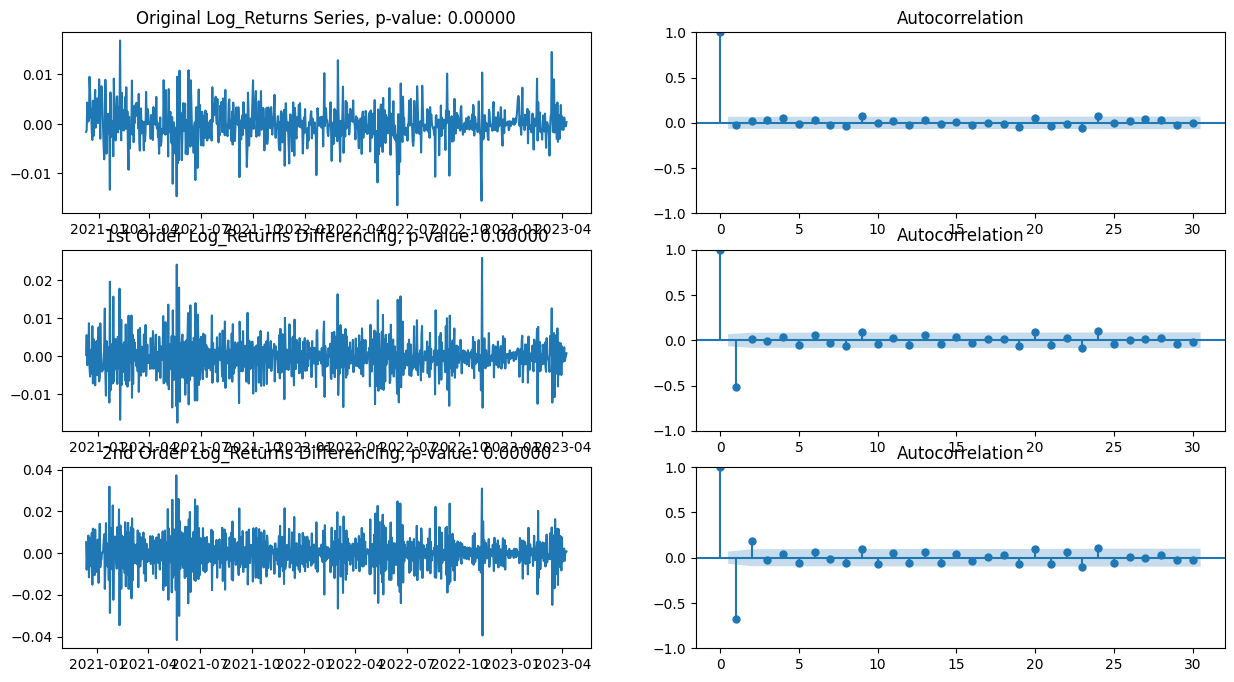

In [106]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

serie = "Log_Returns"

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(15, 8))
axes[0, 0].plot(df_BTC.index, df_BTC[serie])
axes[0, 0].set_title(
    f"Original {serie} Series, p-value: {adfuller(df_BTC[serie].values)[1]:.5f}"
)
plot_acf(df_BTC[serie], ax=axes[0, 1])

# 1st Differencing
diff = df_BTC[serie].diff().dropna()
axes[1, 0].plot(diff.index, diff)
axes[1, 0].set_title(
    f"1st Order {serie} Differencing, p-value: {adfuller(diff.values)[1]:.5f}"
)
plot_acf(diff.dropna(), ax=axes[1, 1])

# 2nd Differencing
diff_diff = diff.diff().dropna()
axes[2, 0].plot(diff_diff.index, diff_diff)
axes[2, 0].set_title(
    f"2nd Order {serie} Differencing, p-value: {adfuller(diff_diff.values)[1]:.5f}"
)
plot_acf(diff_diff.dropna(), ax=axes[2, 1])

plt.show()

No derivative is enough to be stationary.

## Finding $p$ 

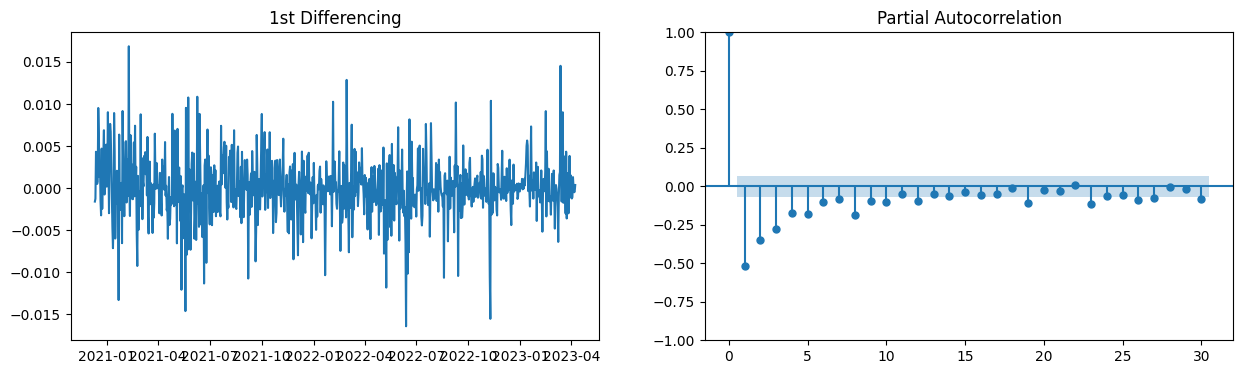

In [107]:
fig, axes = plt.subplots(1, 2,figsize=(15, 4))
axes[0].plot(df_BTC[serie].index, df_BTC[serie].values)
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(diff, ax=axes[1])

plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line. 

## Finding $q$

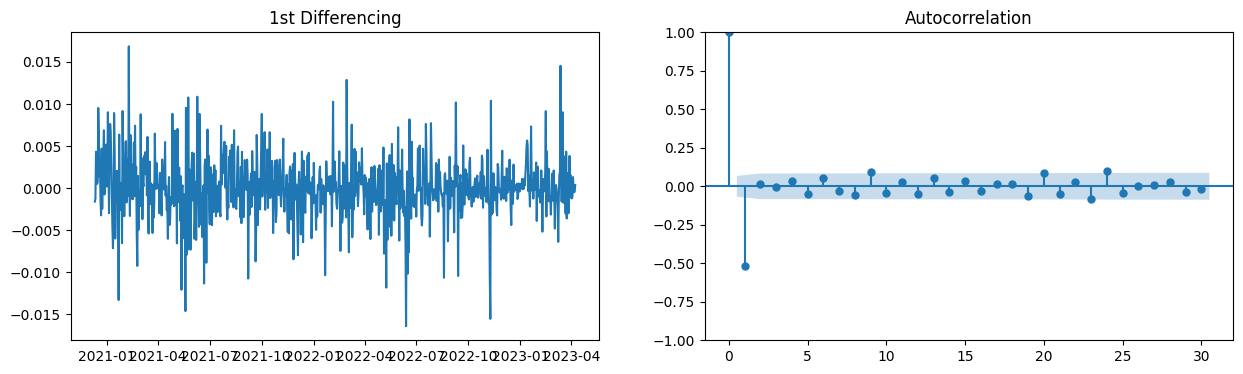

In [108]:
fig, axes = plt.subplots(1, 2,figsize=(15, 4))
axes[0].plot(df_BTC[serie].index, df_BTC[serie].values)
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_acf(diff, ax=axes[1])

plt.show()

You can observe that the ACF lag 1 is quite significant since is well above the significance line. 


# ARIMA Modeling

In [109]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_BTC[serie].values, order=(6,0,2)) #(p, d, q)
model_fit = model.fit()
print(model_fit.summary())

/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  850
Model:                 ARIMA(6, 0, 2)   Log Likelihood                3582.420
Date:                Sat, 08 Apr 2023   AIC                          -7144.840
Time:                        23:17:09   BIC                          -7097.388
Sample:                             0   HQIC                         -7126.663
                                - 850                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.196e-05      0.000      0.366      0.714      -0.000       0.000
ar.L1         -0.0104      0.915     -0.011      0.991      -1.804       1.783
ar.L2          0.0098      0.994      0.010      0.9

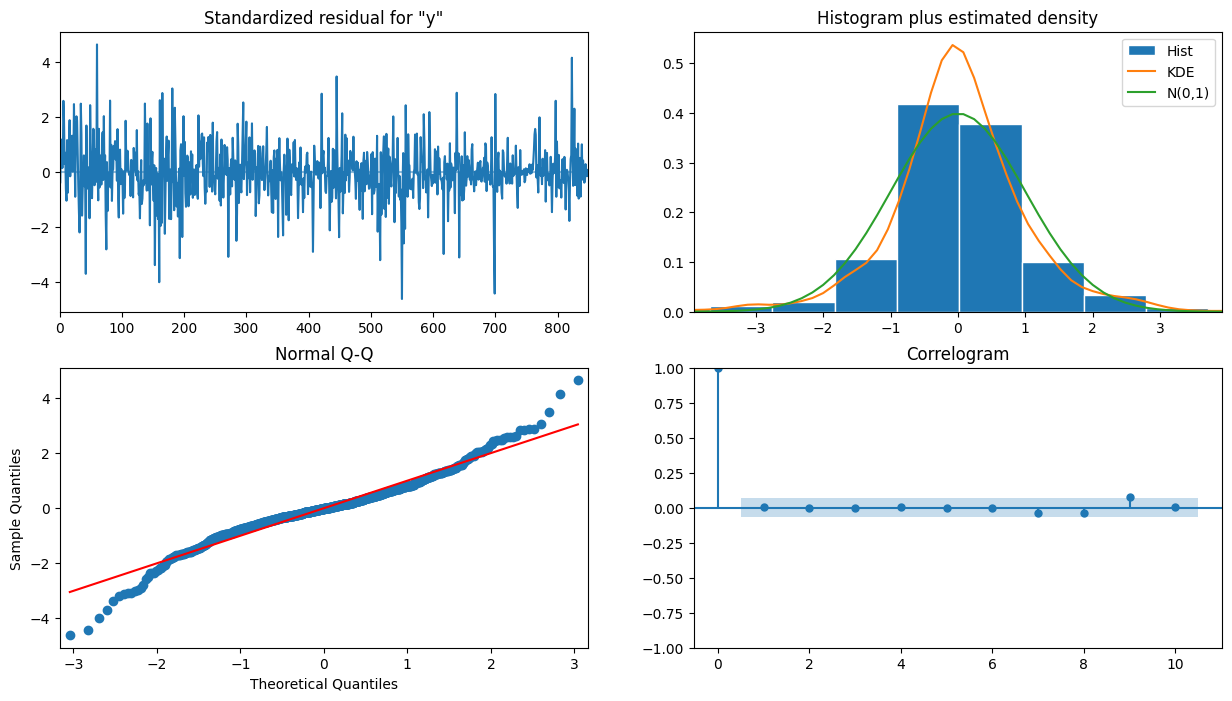

In [110]:
model_fit.plot_diagnostics(figsize=(15, 8))
plt.show()

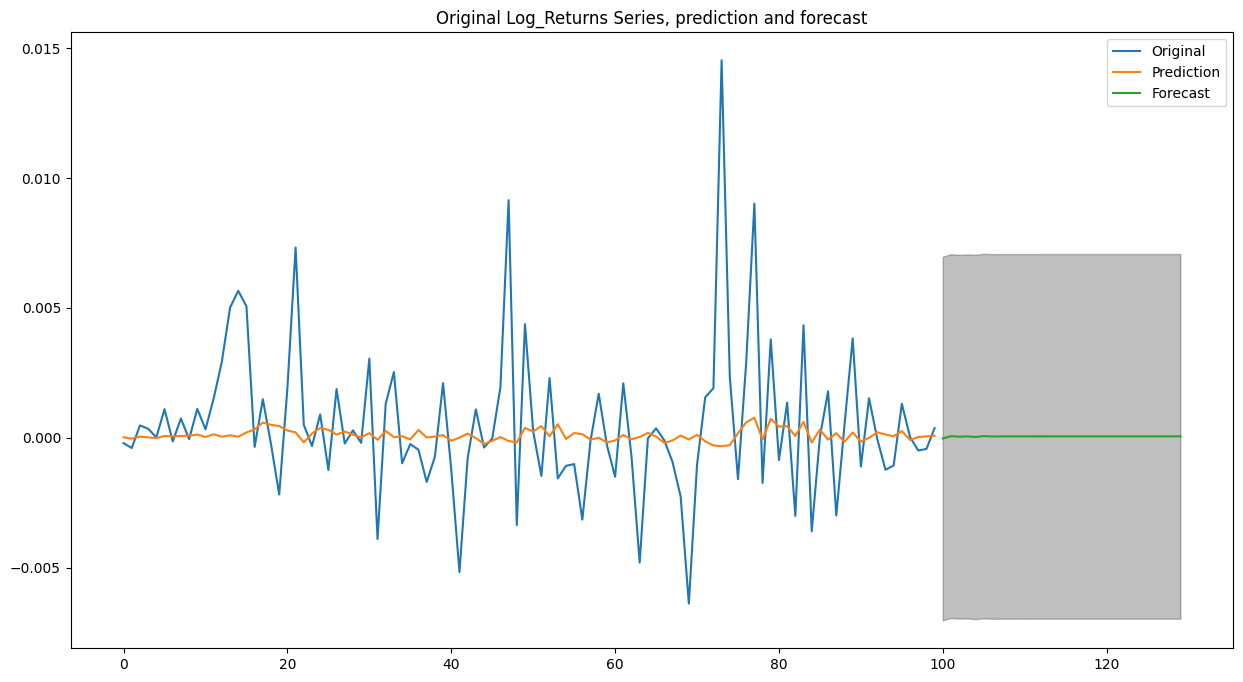

In [111]:
df_to_plot = df_BTC.iloc[-100:]
fitted = model_fit.fittedvalues[-100:]
steps = 30
forecasted = model_fit.get_forecast(steps=steps)


fig, axes = plt.subplots(1, 1, figsize=(15, 8))

orig_x_axis = list(range(len(df_to_plot)))
full_x_axis = list(range(len(df_to_plot)+steps))

axes.plot(orig_x_axis, df_to_plot[serie].values,label="Original")
axes.plot(orig_x_axis, fitted,label="Prediction")
axes.plot(full_x_axis[-steps:], forecasted.predicted_mean,label="Forecast")
axes.fill_between(full_x_axis[-steps:],
                forecasted.conf_int()[:, 0],
                forecasted.conf_int()[:, 1], color='k', alpha=.25)
axes.set_title(
    f"Original {serie} Series, prediction and forecast"
)
axes.legend()


# SARIMA Modeling

Although $p$, $d$, $q$ remain the same, we have to find the same for the seasonal component $P$, $D$, $Q$ parameter to give to the **SARIMAX** model. To do so we will extract the seasonal component from the series using the `seasonal_compose` function from `statsmodels`

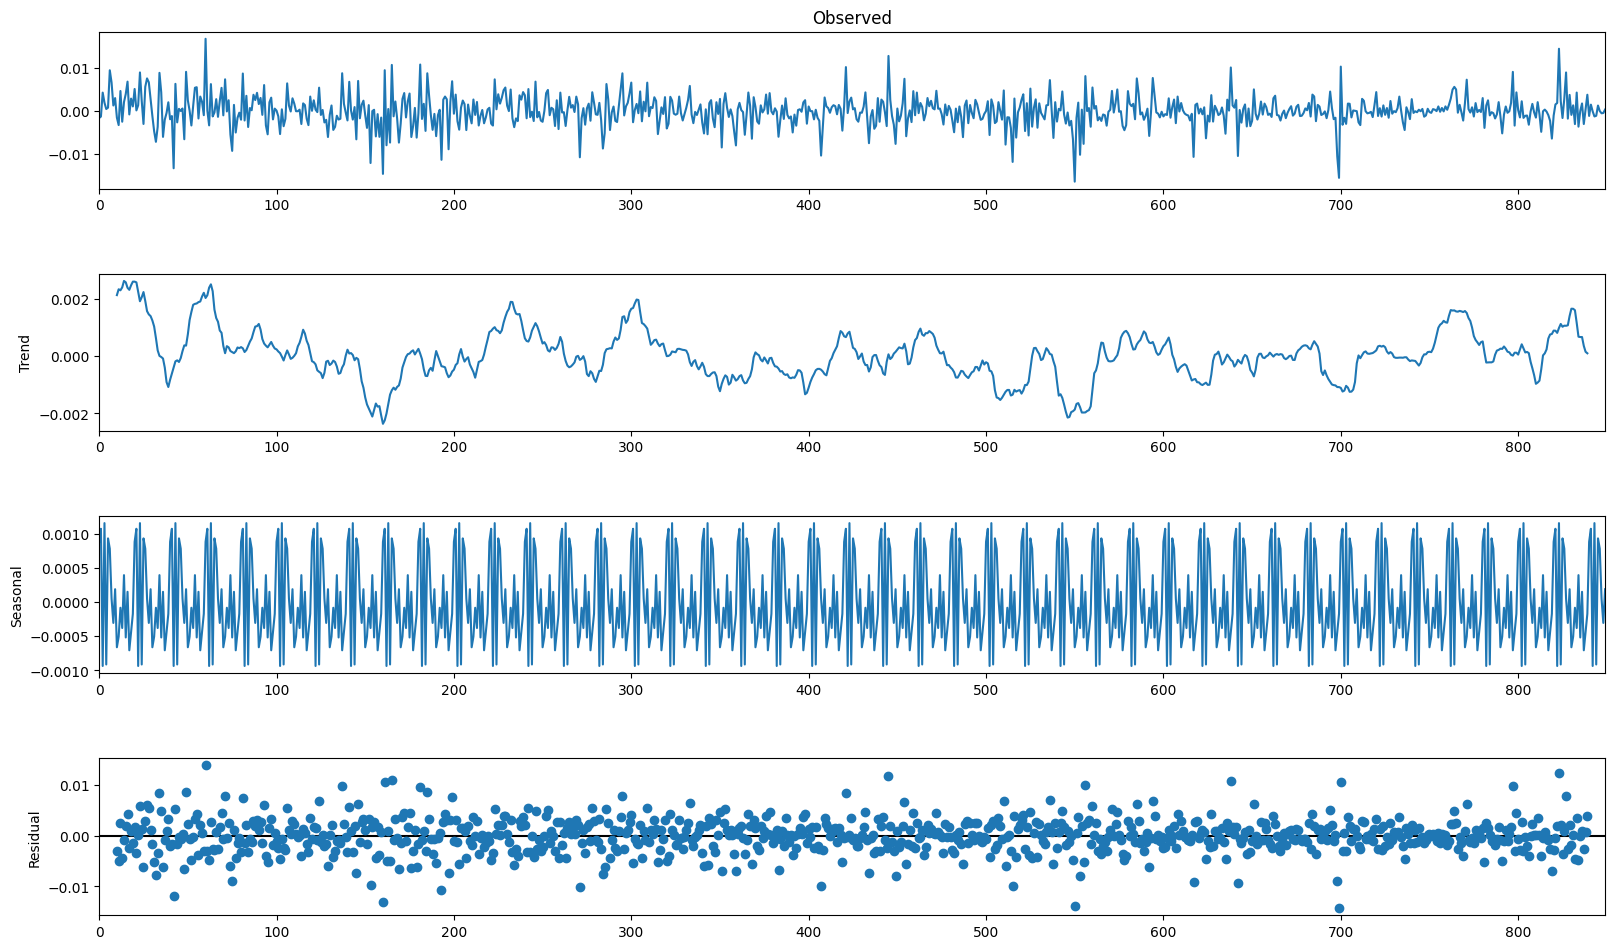

In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(df_BTC[serie].values,model='additive',period=20)
fig = result.plot()
fig.set_size_inches(18.5, 10.5)

In [125]:
season = pd.Series(result.seasonal,name="seasonal")

## Finding $D$

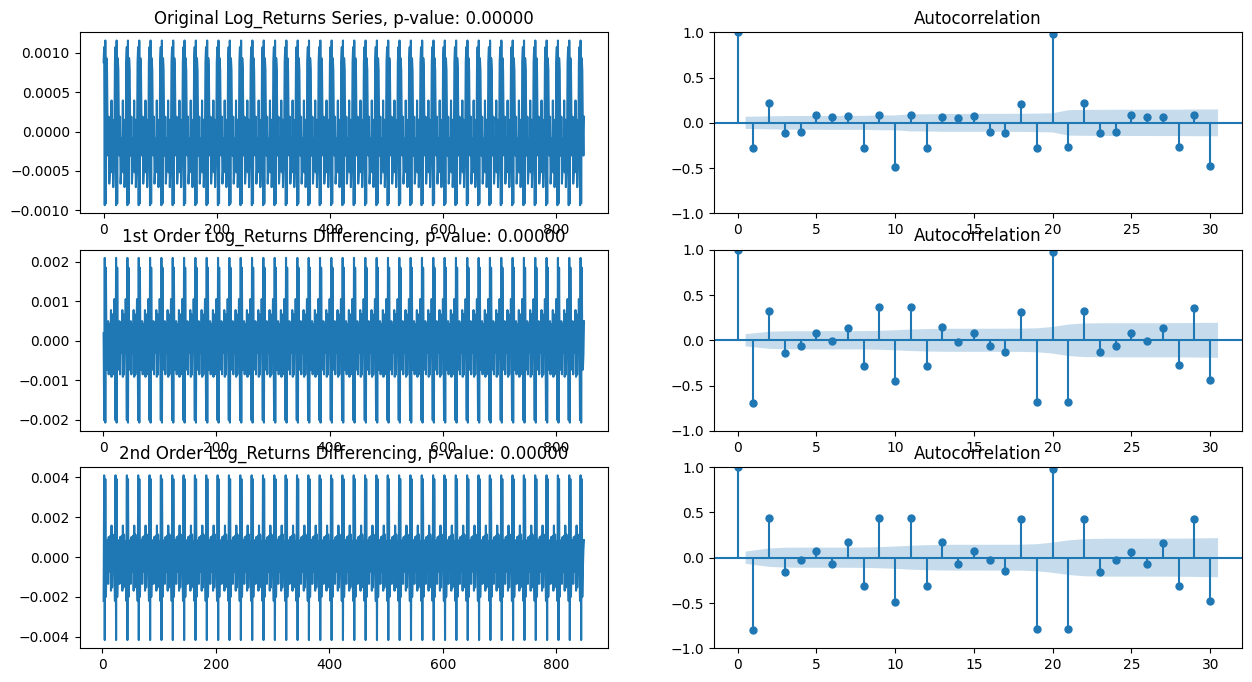

In [126]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt


# Original Series
fig, axes = plt.subplots(3, 2, figsize=(15, 8))
axes[0, 0].plot(season.index,season)
axes[0, 0].set_title(
    f"Original {serie} Series, p-value: {adfuller(season.values)[1]:.5f}"
)
plot_acf(season, ax=axes[0, 1])

# 1st Differencing
diff = season.diff().dropna()
axes[1, 0].plot(diff.index, diff)
axes[1, 0].set_title(
    f"1st Order {serie} Differencing, p-value: {adfuller(diff.values)[1]:.5f}"
)
plot_acf(diff.dropna(), ax=axes[1, 1])

# 2nd Differencing
diff_diff = diff.diff().dropna()
axes[2, 0].plot(diff_diff.index, diff_diff)
axes[2, 0].set_title(
    f"2nd Order {serie} Differencing, p-value: {adfuller(diff_diff.values)[1]:.5f}"
)
plot_acf(diff_diff.dropna(), ax=axes[2, 1])

plt.show() 

## Finding $P$

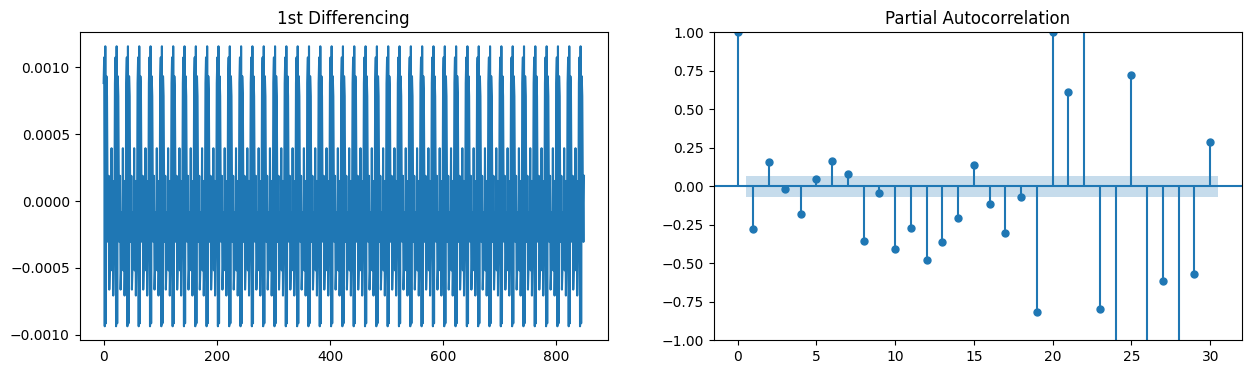

In [128]:
fig, axes = plt.subplots(1, 2,figsize=(15, 4))
axes[0].plot(season.index, season.values)
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(season, ax=axes[1])

plt.show()

## Finding $Q$

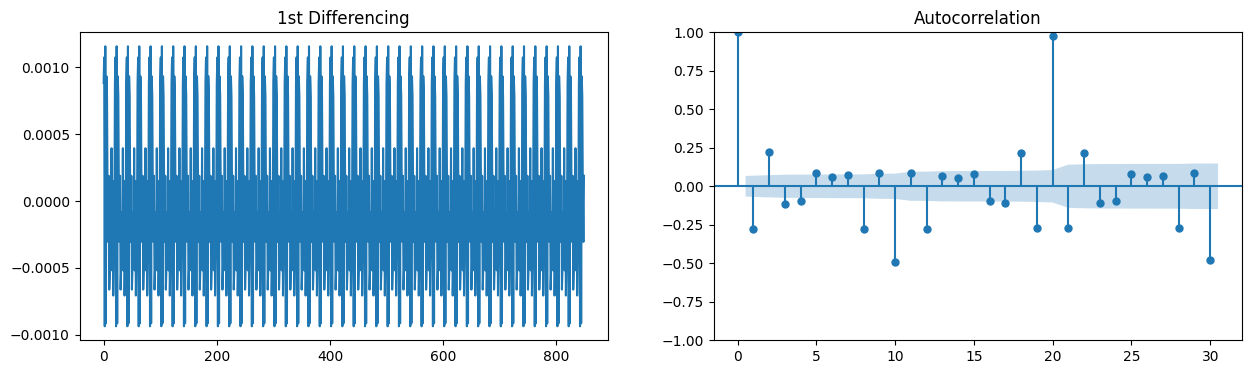

In [129]:
fig, axes = plt.subplots(1, 2,figsize=(15, 4))
axes[0].plot(season.index, season.values)
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_acf(season, ax=axes[1])

plt.show()

In [132]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(df_BTC[serie].values, order=(0,2,2),seasonal_order=(2, 0, 3, 30*12)) #(P,D,Q,s)
sarimax_model_fitted = sarimax_model.fit()
print(model_fit.summary())

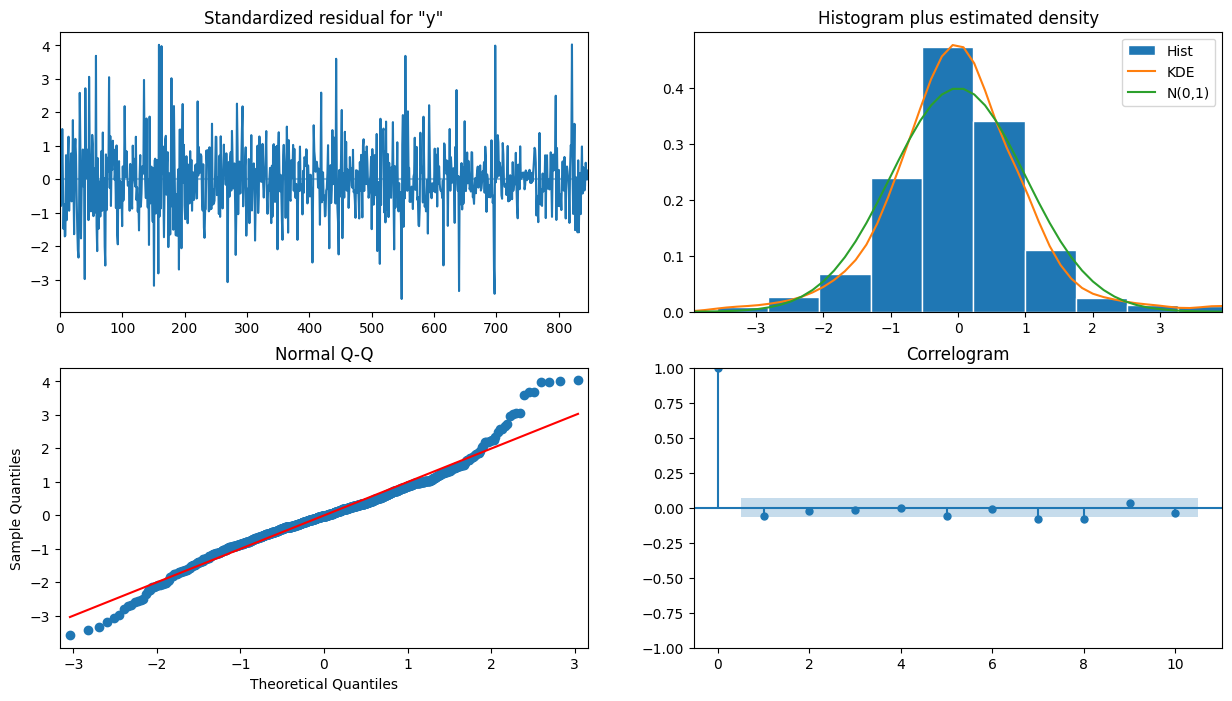

In [93]:
sarimax_model_fitted.plot_diagnostics(figsize=(15, 8))
plt.show()

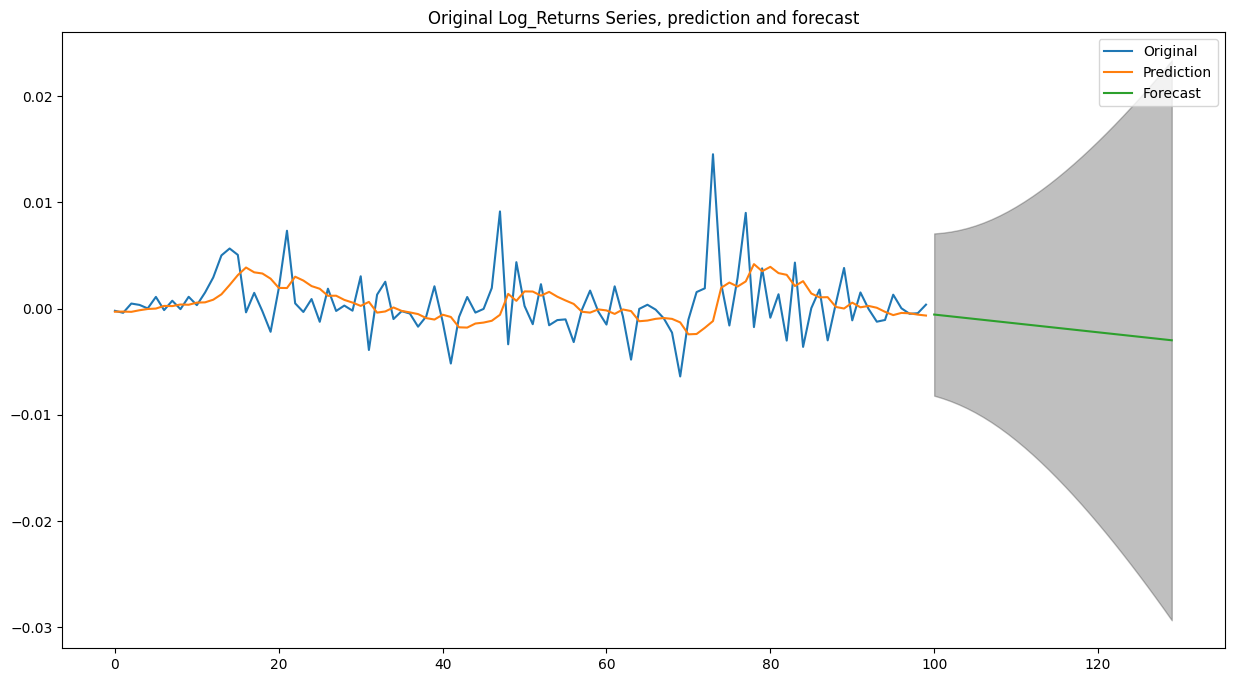

In [94]:
df_to_plot = df_BTC.iloc[-100:]
fitted = sarimax_model_fitted.fittedvalues[-100:]
steps = 30
forecasted = sarimax_model_fitted.get_forecast(steps=steps)


fig, axes = plt.subplots(1, 1, figsize=(15, 8))

orig_x_axis = list(range(len(df_to_plot)))
full_x_axis = list(range(len(df_to_plot)+steps))

axes.plot(orig_x_axis, df_to_plot[serie].values,label="Original")
axes.plot(orig_x_axis, fitted,label="Prediction")
axes.plot(full_x_axis[-steps:], forecasted.predicted_mean,label="Forecast")
axes.fill_between(full_x_axis[-steps:],
                forecasted.conf_int()[:, 0],
                forecasted.conf_int()[:, 1], color='k', alpha=.25)
axes.set_title(
    f"Original {serie} Series, prediction and forecast"
)
axes.legend()
